# Fluxonium-transmon: driving the 11-14 transition

We study a system of capacitively coupled transmon and fluxonium and evaluate wether it is possible to use the $11-14$ transition to implement a two-qubit gate in a similar way as this property to selectively activate the gate between different pairs of qubits following a scheme similar to Ficheux et al. Phys. Rev. X 11, 021026 (2021). In this case, we use the hybridization between the $\lvert 14 \rangle$ and $\lvert 23 \rangle$ levels to induce the gate. In particular, we want to see if we can do this using a fluxonium that already allows the implementation of the same gate, but using the $10-03$ transition.  

In [39]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
import xarray
from itertools import product
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.hsbasis import weyl_by_index
from pysqkit import QubitSystem
from typing import List, Dict, Callable
from matplotlib.ticker import FormatStrFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_ficheux_inspired_gate as util

from IPython.display import display, Latex

In what follows we will mainly analyze how the energy levels of the fluxonium vary as a function of the external flux, but we will also ficticiously introduce a transmon at a certain frequency to see if we can activate the gate. The Hamiltonian of the capacitively coupled system is

$$H = H^{(0)}_T + H^{(0)}_F + V ,$$

$$H^{(0)}_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b},$$

$$H^{(0)}_F = 4 E_{C,F} \cdot \hat{q}^2_F + \frac{1}{2}E_{L,F}\cdot\hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \phi_{ext,F}\right),$$

$$V = J_C \cdot \hat{q}_T \cdot \hat{q}_F.$$

The (approximate) charge operator for the transmon in terms of annihilation and creation operators reads

$$
\hat{q}_T = i \biggl( \frac{E_J}{32 |\delta_T |} \biggr)^{1/4} (b^{\dagger} - b),
$$
where 
$$
E_J = \hbar \biggl(\frac{\omega_T - \delta_T}{8 | \delta_T |} \biggr)^2.
$$

# Introducing the qubits

In [40]:
#Fluxonium
levels_f = 7

# Basic fluxonium from previous analysis
flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0
)
flx.diagonalize_basis(levels_f)

# We introduce a general transmon just to plot the energy levels

levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=4.5, 
    anharm=-0.3,  
    dim_hilbert=levels_t
)

jc = 0.07
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

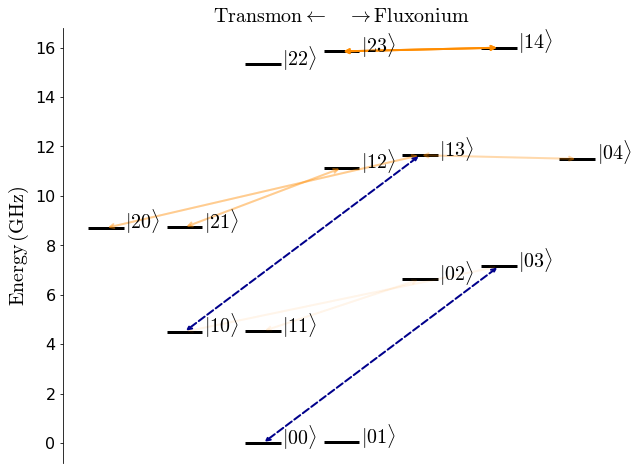

In [41]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04', '14', '22', '23']

util.energy_levels_diagram(bare_system, level_list)

From the previous plot we notice that if we have the possibility to make a gate using the interaction between the $|13 \rangle$ and $\lvert 04 \rangle$ we can also use the same principle to implement a gate using the $\lvert 23 \rangle$-$\lvert 1 4 \rangle$ interaction, but using two drives that are far detuned from each other. In fact, in one case we have to select the drive frequency approximately at the $0-3$ transition of the fluxonium, and in the other case at the $1-4$ transition. As it is apparent from the figure these frequencies are far aways from each other. Hence, if we couple the same transmon to a single-fluxonium, we can use either transitions to implement the gate independently. By further selecting two main frequencies for the transmons, we can in principle couple 4 transmons to a single fluxonium and still be able to implement the gates. Notice however, that the $\vert 04 \rangle is also interacting, which might create problems.

Let us show the matrix elements of the charge operator of the fluxonium to have a clearer picture.

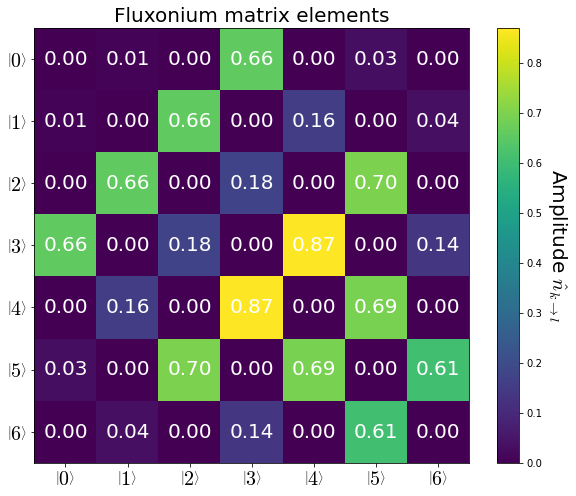

In [42]:
mat_elems_f = flx.mat_elements(operator='charge_op', levels=levels_f, as_xarray=True)
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_mat_elem(
    mat_elems: xarray.core.dataarray.DataArray, 
    levels: int, 
    opt: dict, 
    qubit: str
) -> None:
    levels_vec = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels_vec]
    fig, ax = plt.subplots(figsize=(10,8))
    plt.imshow(np.abs(mat_elems.data), cmap='viridis')
    for in_level, out_level in product(levels_vec, repeat=2):
        amplitude = abs(mat_elems.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center",
                color="white", fontsize=opt['fs'])
    ax.set_xticks(levels_vec)
    ax.set_yticks(levels_vec)
    ax.set_xticklabels(level_labels, fontsize=opt['fs'])
    ax.set_yticklabels(level_labels, fontsize=opt['fs'])

    cbar = plt.colorbar()
    cbar.ax.set_ylabel(r"Amplitude $\hat{n}_{k \rightarrow l}$", rotation=-90, va="bottom", fontsize=opt['fs'])
    ax.set_title(qubit + ' matrix elements', fontsize=opt['fs'])
    plt.show()

plot_mat_elem(mat_elems_f, levels_f, plot_setup, 'Fluxonium')

We notice however that the $1-4$ transition can be driven, but the matrix element is approximately $1/4$ the matrix element of the $0-3$ transition. Let us obtain the $ZZ$ coupling and the $\Delta$ of the two transitions, namely



In [43]:
def zz(system: QubitSystem) -> float:
    xi_zz = system.state('00')[0] + system.state('11')[0] \
        - system.state('01')[0] - system.state('10')[0]
    return xi_zz

def delta_10_13(system: QubitSystem) -> float:
    delta_gate = (system.state('13')[0] - system.state('10')[0]) - \
        (system.state('03')[0] - system.state('00')[0])
    return delta_gate 

def delta_11_14(system: QubitSystem) -> float:
    delta_gate = (system.state('14')[0] - system.state('11')[0]) - \
        (system.state('04')[0] - system.state('01')[0])
    return delta_gate

display(Latex(r'$\xi_{{ZZ}}/2\pi = {:.5f} \, \mathrm{{GHz}}$'.format(zz(coupled_sys))))
display(Latex(r'$\Delta_{{10-13}}/2\pi = {:.5f} \, \mathrm{{MHz}}$'.format(1e3*delta_10_13(coupled_sys))))
display(Latex(r'$\Delta_{{11-14}}/2\pi = {:.5f} \, \mathrm{{MHz}}$'.format(1e3*delta_11_14(coupled_sys))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Thus, despite the smaller matrix element we have a larger $\Delta$ so we can still implement the gate using similar drive powers. However, we should look for transmon frequencies such that $\Delta_{10-02}$ is large and $\Delta_{11-14}$ is small and $\xi_{ZZ}$ is always small.

In [52]:
n_points = 100
omega_trans = np.linspace(4.0, 5.0, n_points)
xi_zz_array = np.zeros(n_points)
delta_10_13_array = np.zeros(n_points)
delta_11_14_array = np.zeros(n_points)
for omega, k in zip(omega_trans, range(n_points)):
    transm_tmp = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq=omega, 
        anharm=-0.3,  
        dim_hilbert=levels_t
    )
    coupled_sys_tmp = transm_tmp.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    xi_zz_array[k] = zz(coupled_sys_tmp)
    delta_10_13_array[k] = delta_10_13(coupled_sys_tmp) 
    delta_11_14_array[k] = delta_11_14(coupled_sys_tmp) 

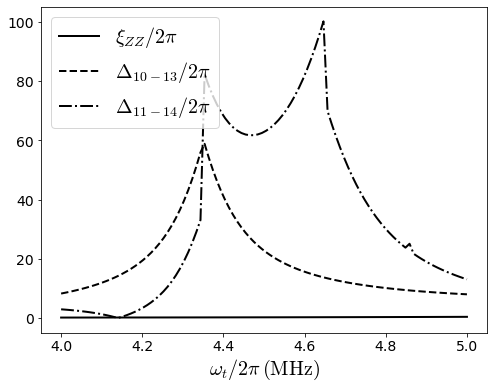

In [53]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_deltas(
    omega_trans: np.ndarray,
    xi_zz_array: np.ndarray,
    delta_10_13_array: np.ndarray,
    delta_11_14_array: np.ndarray,
    opt: dict
):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(omega_trans, 1e3*np.abs(xi_zz_array), linewidth=opt["lw"], 
            color="black", linestyle='-', label="$\\xi_{ZZ}/2 \pi$")
    ax.plot(omega_trans, 1e3*np.abs(delta_10_13_array), linewidth=opt["lw"], 
            color="black", linestyle='--', label="$\\Delta_{10-13}/2\pi$")
    ax.plot(omega_trans, 1e3*np.abs(delta_11_14_array), linewidth=opt["lw"], 
            color="black", linestyle='-.', label="$\\Delta_{11-14}/2\pi$")
    ax.axes.set_xlabel("$\omega_t/2 \pi \, \mathrm{(MHz)}$", fontsize=opt["fs"])
    ax.legend(fontsize=opt["fs"])
    ax.tick_params(axis="both", labelsize=opt["ls"])
    plt.show()

plot_deltas(omega_trans, xi_zz_array, delta_10_13_array, delta_11_14_array, plot_setup)
    
    

Idea: use AC Stark shift to trigger the gate selectively.